In [1]:
from sklearn import preprocessing
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFE, VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pandas as pd 
import numpy as np 
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
def normalize(data_frame, columns):
    """
    Normalizing (loged) column values
    :param data_frame: A pandas DataFrame to be processed
    :param columns: List of column names of categorical variables 
    :returns data_frame: DataFrame with normalizedcolumns
    """    
    for col in columns:
        data_frame[col] = log_colum_values(data_frame[col])
    return data_frame

def log_colum_values(series_col):
    """
    Normalizing (loged) column values
    :param series_col: Column of dataframe 
    :returns np array: DataFrame with normalizedcolumns
    """    
    min_val = series_col.min()
    values = [log_value(v, min_val)for v in series_col.values]
    return values

def log_value(x, min_val):
    """
    Logs a value, replacing -inf with 0 and handling negative values
    :param x: value
    :param min_val: min value in list 
    :returns value: loged numerical value
    """    
    if x>0:
        return np.log(x)
    if np.log(x) == -inf:
        return 0 
    if x < 0:
#         print("na")
        return np.log(x + 1 - min_val)

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame

def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame

def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_regression, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_regression, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def get_features_variance_threshold(data_frame,target="gender", threshold=0.2):
    """
    Returns list of features with a variance above the specified threshold
    :param data_frame: A pandas dataFrame with the training data
    :param threshold: float value between 0 and 1 
    :returns feature_scores: list of features
    """
    if target in data_frame.columns:
        data_frame = data_frame.drop([target], axis=1)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
#     print(feat_ix_keep)
    return data_frame.columns[feat_ix_keep]

def get_features_univariate(data_frame, k=5, linear=True, target="gender"):
    """
    Returns list of features selected using the specified univariate method
    :param data_frame: A pandas dataFrame with the training data
    :param k: top k features to select  
    :returns data_frame: with selected features
    """
    df = show_kbest(data_frame,target=target,linear_rel=linear, k=k)
    df = df[df["Support"] == True]
    columns = df["Attribute"].values
    return columns

def get_features_rfe(data_frame,model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame.drop("gender", axis=1)
    y = data_frame["gender"]
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return list(df[df["support"] == True]["feature"])

def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data_frame.drop([target], axis=1)
    y = pd.DataFrame(data_frame[target], columns=[target])
    return X, y 

def model_score(X,y, model):
    """
    Cross validation scores - R^2,mae,mse...
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model: Sklearn estimator object
    :returns tuple: name, r^2, mae, nmsle, mse
    """ 
    r2 = cross_val_score(model, X, y,cv=10,scoring="r2").mean()
    mae = cross_val_score(model, X, y,cv=10,scoring="median_absolute_error").mean()
    msle = cross_val_score(model, X, y,cv=10,scoring="mean_absolute_error").mean()
    mse = cross_val_score(model, X, y,cv=10,scoring="mean_squared_error").mean()
    return r2,mae,msle,mse
def score_comparison(X,y, model_dict, col_names=["Model","R^2","MEDAE","MAE","MSE"]):
    """
    DataFrame with model scores
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets
    :param model_dict: Model names are keys, sklearn estimatir objects
    :param col_names: Names of DataFrame columns
    :returns tuple: name, r^2, mae, nmsle, mse
    """ 
    lst = []
    for name,model in model_dict.items():
        r2,mae,msle,mse = model_score(X,y,model)
        lst.append([name,r2,mae,msle,mse])
    return pd.DataFrame(lst, columns=col_names)

def model_coefs(X,y, model_dict):
    """
    Returns a dataframe with coefficients for each of the models
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model_dict: Model names are keys, sklearn estimatir objects
    :returns data_frame: DataFrame with coefficients for each of the models
    """ 
    dic  = {}
    for name, model in model_dict.items():
        m = model.fit(X,y)
        try:
            dic[name] = m.coef_.flatten()
        except:
            None
    dic["Attribute"] = X.columns
    
    return pd.DataFrame(dic)

def important_features(X,y, model_dict):
    """
    Returns a dataframe with feature importance scores for each of the models
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model_dict: Model names are keys, sklearn estimatir objects
    :returns data_frame: DataFrame with feature importance scores for each of the models
    """ 
    dic  = {}
    for name, model in model_dict.items():
        m = model.fit(X,y)
        try:
            dic[name] = m.feature_importances_
        except:
            None
    dic["Attribute"] = X.columns
    
    return pd.DataFrame(dic)

def comparison_over_countries(country_dict,model,path,col_names=["Country","R^2","MEDAE","MAE","MSE"]): 
    """
    Returns a DataFrame with a comparison of results 
    :param country_dict: Dicrionary with country_name : file_name
    :param model: Sklearn estimator object
    :param col_names: Names of columns to be added
    :return data_frame: DataFrame with results
    """
    lst = []
    for country, file in country_dict.items():
        data = pd.read_pickle("{}/{}".format(path, file))
        data = preprocess_data_frame(data,["gender"])
        data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        X,y = split_dataframe(data,"views")
        r2,mae,msle,mse = model_score(X,y,model)
        lst.append([country,r2,mae,msle,mse])
    return pd.DataFrame(lst, columns=col_names)

def merge_by(df_lst, repeat="Attribute"):
    """
    Merge on Attribute
    :param df_lst: List of dataframes
    :return data_frame: 
    """
    df = pd.concat(df_lst, axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    return df

def print_latex(df, col_format="|c|c|c|c|c|"):
    """ Prints the latex syntax equivalent to the passed dataframe
    :param df: Pandas dataframe 
    :col_format : String indicating the format of columns
    """
    df = df.round(2)
    latex = df.to_latex(column_format=col_format, index=False).replace('toprule',
                                            "hline").replace('midrule',
                                            "hline").replace('bottomrule',
                                            "hline").replace("\\\\\n",
                                            "\\\\\n\\hline").replace("\hline\hline","\hline")
    print(latex)

# Load the data

In [5]:
data = pd.read_pickle("../data/final_sets/countries/model_large/2016_american")

In [6]:
data = preprocess_data_frame(data,["gender"])

['female', 'male']
{0, 1}


In [7]:
data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])

In [8]:
X,y = split_dataframe(data,"views")

In [9]:
# X.shape

In [10]:
# y

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=y.columns)
y_test =pd.DataFrame(y_test, columns=y.columns)

In [12]:
# show_kbest(data,target="views",linear_rel=False,k=5)

In [13]:
# get_features_variance_threshold(data,target="views",threshold=0.8)

In [14]:
# reg.coef_

# Views Distribution

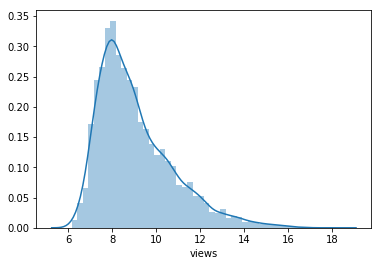

In [15]:
sns.distplot(data["views"])

# Algorithms

In [16]:
#Linear Regression
lin_reg = linear_model.LinearRegression()
#Ridge Regression
ridge = linear_model.Ridge(alpha = .5)
#Lasso Regression
lasso = linear_model.Lasso(alpha = 0.1)
#Decision Tree Regressor
d_tree = DecisionTreeRegressor(random_state=0)
#Random Forest Regressor 
r_forest = RandomForestRegressor(max_depth=2, random_state=0)

In [17]:
model_dict = {
    "Linear Regression":lin_reg,
    "Lasso Regression": lasso,
#     "Ridge Regression": ridge,
    "Decision Tree Regressor": d_tree,
    "Random Forest Regressor": r_forest
}

# F-scores

In [18]:
show_kbest(data, "views", linear_rel=True,k=5)

,F Score,P Value,Support,Attribute
0,40.768458,1.878188e-10,False,gender
1,1726.354863,6.126414e-322,True,entered
2,8.583088,3.409219e-03,False,efficiency
3,309.900189,3.075019e-67,False,eig_central
4,2624.442720,0.000000e+00,True,in_degree
5,2031.245617,0.000000e+00,True,k_core
6,1921.457065,0.000000e+00,True,out_degree
7,126.401599,5.835242e-29,False,age
8,2.055343,1.517392e-01,False,distance_birth
9,12.890659,3.335775e-04,False,distance_death


# Mutual Information

In [19]:
show_kbest(data, "views", linear_rel=False,k=5)

,Mutual Information,P Value,Support,Attribute
0,0.005005,None,False,gender
1,0.272116,None,True,entered
2,0.144201,None,False,efficiency
3,0.255143,None,True,eig_central
4,0.215336,None,True,in_degree
5,0.220074,None,True,k_core
6,0.155134,None,False,out_degree
7,0.030115,None,False,age
8,0.065860,None,False,distance_birth
9,0.027656,None,False,distance_death


# Model Comparison

In [20]:
df = score_comparison(X,y,model_dict)

In [21]:
df

,Model,R^2,MEDAE,MAE,MSE
0,Linear Regression,0.527334,-0.708503,-0.873636,-1.290383
1,Lasso Regression,0.431187,-0.781796,-0.963862,-1.563328
2,Decision Tree Regressor,0.246539,-0.800669,-1.070681,-2.076386
3,Random Forest Regressor,0.440422,-0.791664,-0.948919,-1.537328


In [22]:
print_latex(df)

\begin{tabular}{|c|c|c|c|c|}
\hline
                   Model &   R\textasciicircum 2 &  MEDAE &   MAE &   MSE \\
\hline
       Linear Regression &  0.53 &  -0.71 & -0.87 & -1.29 \\
\hline        Lasso Regression &  0.43 &  -0.78 & -0.96 & -1.56 \\
\hline Decision Tree Regressor &  0.25 &  -0.80 & -1.07 & -2.08 \\
\hline Random Forest Regressor &  0.44 &  -0.79 & -0.95 & -1.54 \\
\hline
\end{tabular}



# Feature Importance

In [23]:
model_coefs(X,y,model_dict).sort_values(by="Linear Regression",ascending=False).round(4)

,Linear Regression,Lasso Regression,Attribute
8,2.343853e+10,-0.0018,distance_birth
32,1.458732e+08,0.0000,year_interval_1
34,1.458732e+08,0.0000,year_interval_3
33,1.458732e+08,-0.3094,year_interval_2
26,4.495585e+04,0.0000,party2
22,1.871600e+00,0.0000,act
14,6.287000e-01,0.0000,wrt
4,5.491000e-01,0.4588,in_degree
6,4.353000e-01,0.1767,out_degree
23,2.430000e-01,0.0000,ply


In [24]:
important_features(X,y,model_dict)

,Decision Tree Regressor,Random Forest Regressor,Attribute
0,0.014001,0.000000,gender
1,0.049245,0.130052,entered
2,0.035179,0.000000,efficiency
3,0.107249,0.000000,eig_central
4,0.057398,0.071643,in_degree
5,0.170043,0.147809,k_core
6,0.020811,0.023992,out_degree
7,0.027659,0.000000,age
8,0.034938,0.000000,distance_birth
9,0.018374,0.000000,distance_death


In [25]:
merge_by([important_features(X,y,model_dict),model_coefs(X,y,model_dict)])

,Decision Tree Regressor,Random Forest Regressor,Attribute,Linear Regression,Lasso Regression
0,0.014001,0.000000,gender,-3.883384e-01,-0.000000
1,0.049245,0.130052,entered,-1.240300e-01,-0.156472
2,0.035179,0.000000,efficiency,-1.508534e-01,-0.000000
3,0.107249,0.000000,eig_central,4.902531e-03,0.005656
4,0.057398,0.071643,in_degree,5.491083e-01,0.458806
5,0.170043,0.147809,k_core,-3.250874e-01,0.000000
6,0.020811,0.023992,out_degree,4.352929e-01,0.176662
7,0.027659,0.000000,age,-6.508540e-03,0.000000
8,0.034938,0.000000,distance_birth,2.343853e+10,-0.001811
9,0.018374,0.000000,distance_death,-2.343853e+10,-0.000418


## Country comparison

In [26]:
country_dict = {
    "USA": "2016_american",
    "Germany": "2016_german",
    "France": "2016_french",
    "GB": "2016_british",
    "Russia": "2016_russian",
} 

In [27]:
path = "../data/final_sets/countries/model"
df = comparison_over_countries(country_dict, lin_reg, path)

['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}


In [28]:
df.round(2)

,Country,R^2,MEDAE,MAE,MSE
0,USA,0.49,-0.73,-0.91,-1.41
1,Germany,0.50,-0.69,-0.81,-1.05
2,France,0.56,-0.58,-0.72,-0.87
3,GB,0.35,-0.64,-0.74,-0.90
4,Russia,0.47,-0.68,-0.82,-1.14


In [29]:
path = "../data/final_sets/countries/model_large"
df = comparison_over_countries(country_dict, lin_reg, path)

['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}


In [30]:
df

,Country,R^2,MEDAE,MAE,MSE
0,USA,5.273336e-01,-0.708503,-0.873636,-1.290383e+00
1,Germany,-3.114739e+12,-0.689215,-64802.952684,-5.501106e+12
2,France,5.728113e-01,-0.557971,-0.705901,-8.454347e-01
3,GB,3.165208e-01,-0.622561,-0.756866,-9.361415e-01
4,Russia,5.161640e-01,-0.647498,-0.771928,-9.819540e-01


In [31]:
print_latex(df)

\begin{tabular}{|c|c|c|c|c|}
\hline
 Country &           R\textasciicircum 2 &  MEDAE &       MAE &           MSE \\
\hline
     USA &  5.300000e-01 &  -0.71 &     -0.87 & -1.290000e+00 \\
\hline Germany & -3.114739e+12 &  -0.69 & -64802.95 & -5.501106e+12 \\
\hline  France &  5.700000e-01 &  -0.56 &     -0.71 & -8.500000e-01 \\
\hline      GB &  3.200000e-01 &  -0.62 &     -0.76 & -9.400000e-01 \\
\hline  Russia &  5.200000e-01 &  -0.65 &     -0.77 & -9.800000e-01 \\
\hline
\end{tabular}



In [32]:
def feature_importances(country_dict, path, model_dict):
    lst = []
    for country, file in country_dict.items():
        data = pd.read_pickle("{}/{}".format(path, file))
        data = preprocess_data_frame(data,["gender"])
        data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        X,y = split_dataframe(data,"views")
        lst.append(model_coefs(X,y,model_dict).sort_values(by="Attribute",ascending=False).drop(["Lasso Regression"], axis =1).round(4))
    return lst

In [38]:
path = "../data/final_sets/countries/model/"
lst = feature_importances(country_dict, path, model_dict)

['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}


In [39]:
df = pd.DataFrame({
    "Attribute": lst[0]["Attribute"].values,
    "USA":lst[0]["Linear Regression"].values,
    "Germany":lst[1]["Linear Regression"].values,
    "France":lst[2]["Linear Regression"].values,
    "Great Britain":lst[3]["Linear Regression"].values,
    "Russia":lst[4]["Linear Regression"].values  
})

In [40]:
df

,Attribute,USA,Germany,France,Great Britain,Russia
0,year_interval_3,0.0980,0.1790,0.1864,-0.1232,0.1049
1,year_interval_2,-0.4456,-0.1745,-0.0158,-0.1885,-0.2126
2,year_interval_1,0.3477,-0.0045,-0.1706,0.3116,0.1077
3,party_num,0.0044,-0.1129,0.0881,-0.0792,0.0366
4,out_degree,0.4793,0.3926,0.4573,0.3032,0.3279
5,other_p,0.0000,-0.0000,0.0000,0.0000,-0.0000
6,occupation_num,0.0972,0.0786,0.1899,0.0968,0.1481
7,nationality_num,0.0651,0.1074,0.4577,0.0677,0.0554
8,k_core,-0.4166,-0.3749,-0.3305,-0.0772,-0.2120
9,is_alive_yes,0.5067,0.0809,0.3475,0.6344,0.3914


In [36]:
print_latex(df)

\begin{tabular}{|c|c|c|c|c|}
\hline
        Attribute &           USA &  Germany &  France &  Great Britain &  Russia \\
\hline
  year\_interval\_3 &  1.458732e+08 &     0.18 &    0.16 &          -0.09 &    0.07 \\
\hline  year\_interval\_2 &  1.458732e+08 &    -0.18 &   -0.01 &          -0.18 &   -0.20 \\
\hline  year\_interval\_1 &  1.458732e+08 &    -0.00 &   -0.16 &           0.27 &    0.13 \\
\hline              wrt &  6.300000e-01 &     0.10 &   -0.39 &           0.25 &    0.04 \\
\hline              spo &  1.000000e-01 &    -0.39 &    0.05 &           0.48 &    2.58 \\
\hline              sci &  1.300000e-01 &     0.59 &   -0.33 &           0.20 &   -0.10 \\
\hline              ply &  2.400000e-01 &     0.60 &   -0.51 &          -1.51 &   -0.43 \\
\hline              phs & -2.300000e-01 &    -0.26 &   -1.42 &          -0.80 &   -0.26 \\
\hline        party\_num &  5.000000e-02 &    -0.11 &    0.10 &          -0.10 &    0.08 \\
\hline           party3 & -2.082610e+03 &     0.00 &

In [37]:
coefficients = model_coefs(X,y,model_dict).sort_values(by="Linear Regression",ascending=False).drop(["Lasso Regression"], axis =1).round(4)
coefficients.round(4)

,Linear Regression,Attribute
8,2.343853e+10,distance_birth
32,1.458732e+08,year_interval_1
34,1.458732e+08,year_interval_3
33,1.458732e+08,year_interval_2
26,4.495585e+04,party2
22,1.871600e+00,act
14,6.287000e-01,wrt
4,5.491000e-01,in_degree
6,4.353000e-01,out_degree
23,2.430000e-01,ply


In [133]:
import statsmodels.api as sm
from scipy import stats

def p_to_star(p_value):
    if p_value <= 0.001:
        return "***"
    if p_value <= 0.01:
        return "**"
    if p_value <= 0.05:
        return "*"
    return ""

def generate_coef_plot(country_dict,path):
    lst = []
    for k,v in country_dict.items():
        data = pd.read_pickle("{}/{}".format(path, v))
        data = preprocess_data_frame(data,["gender"])
        data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        X,y = split_dataframe(data,"views")
        X2 = sm.add_constant(X)
        est = sm.OLS(y, X2)
        est2 = est.fit()
        p_v = pd.DataFrame(round(est2.pvalues,5), columns=["p_value"])
        coef = pd.DataFrame(round(est2.params,4),columns=["coef"])
        df = pd.concat([coef,p_v],axis=1)
        df["p_value"] = df["p_value"].apply(lambda x: p_to_star(x))
        df[k] = df.apply(lambda x: str(x["coef"])+x["p_value"], axis=1)
        lst.append(df[k])
        df = pd.concat(lst,axis=1)
        x = df.index.values
        x = pd.Series(x, index=df.index)
        x = x.replace({
            "wrt":"writer",
            "sci":"scientist",
            "jur":"journalist",
            "eco":"economist",
            "hst":"historian",
            "spo":"athleate",
            "lyr":"lawyer",
            "phs":"physician",
            "act":"actor",
            "distance_birth":"d_birth",
            "distance_death":"d_death",
            "nationality_num":"nationalities",
            "occupation_num":"occupations",
            "year_interval_1":"interval_1",
            "year_interval_2":"interval_2",
            "year_interval_3":"interval_3",
            "is_alive_unknown":"alive_unknown",
            "is_alive_yes":"is_alive"
        })
        df["Attribute"] = x
    return df

In [135]:
path = "../data/final_sets/countries/model_large/"
table = generate_coef_plot(country_dict, path)

['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}


In [136]:
table

,USA,Germany,France,GB,Russia,Attribute
gender,-0.3892***,-0.0121,-0.1517,-0.1287,-0.461**,gender
entered,-0.1241***,-0.1237***,-0.0965***,-0.0037,-0.0561,entered
efficiency,-0.153,-0.2633,0.5149***,0.4733,-0.2604,efficiency
eig_central,0.0049***,0.0047*,0.0024,0.0089**,0.0082**,eig_central
in_degree,0.5486***,0.7469***,0.7603***,0.4346***,0.7517***,in_degree
k_core,-0.324***,-0.3476**,-0.3523***,-0.0682,-0.0535,k_core
out_degree,0.4354***,0.3845***,0.4668***,0.3094**,0.3169**,out_degree
age,-0.0065***,-0.0022,-0.0087***,-0.0014,0.0013,age
distance_birth,0.0004,-0.001,0.0021***,0.0003,0.0001,d_birth
distance_death,0.001**,0.0009,0.0025***,-0.0002,0.0015,d_death


In [138]:
cols = table.columns.tolist()
cols = cols[-1:] + cols[:-1]
table = table[cols]

In [139]:
table

,Attribute,USA,Germany,France,GB,Russia
gender,gender,-0.3892***,-0.0121,-0.1517,-0.1287,-0.461**
entered,entered,-0.1241***,-0.1237***,-0.0965***,-0.0037,-0.0561
efficiency,efficiency,-0.153,-0.2633,0.5149***,0.4733,-0.2604
eig_central,eig_central,0.0049***,0.0047*,0.0024,0.0089**,0.0082**
in_degree,in_degree,0.5486***,0.7469***,0.7603***,0.4346***,0.7517***
k_core,k_core,-0.324***,-0.3476**,-0.3523***,-0.0682,-0.0535
out_degree,out_degree,0.4354***,0.3845***,0.4668***,0.3094**,0.3169**
age,age,-0.0065***,-0.0022,-0.0087***,-0.0014,0.0013
distance_birth,d_birth,0.0004,-0.001,0.0021***,0.0003,0.0001
distance_death,d_death,0.001**,0.0009,0.0025***,-0.0002,0.0015


In [140]:
print_latex(table)

\begin{tabular}{|c|c|c|c|c|}
\hline
      Attribute &          USA &      Germany &       France &         GB &     Russia \\
\hline
         gender &   -0.3892*** &      -0.0121 &      -0.1517 &    -0.1287 &   -0.461** \\
\hline        entered &   -0.1241*** &   -0.1237*** &   -0.0965*** &    -0.0037 &    -0.0561 \\
\hline     efficiency &       -0.153 &      -0.2633 &    0.5149*** &     0.4733 &    -0.2604 \\
\hline    eig\_central &    0.0049*** &      0.0047* &       0.0024 &   0.0089** &   0.0082** \\
\hline      in\_degree &    0.5486*** &    0.7469*** &    0.7603*** &  0.4346*** &  0.7517*** \\
\hline         k\_core &    -0.324*** &    -0.3476** &   -0.3523*** &    -0.0682 &    -0.0535 \\
\hline     out\_degree &    0.4354*** &    0.3845*** &    0.4668*** &   0.3094** &   0.3169** \\
\hline            age &   -0.0065*** &      -0.0022 &   -0.0087*** &    -0.0014 &     0.0013 \\
\hline        d\_birth &       0.0004 &       -0.001 &    0.0021*** &     0.0003 &     0.0001 \\
\hli

In [10]:
data = pd.read_pickle("../data/connected_sources/2016")
data.head()

,#DBpURL,ID,WikiURL,birthDate,deathDate,first_name,full_name,gender,name,nationality,...,party,entered,efficiency,eig_central,id,in_degree,k_core,out_degree,name_u,views
0,http://dbpedia.org/resource/Nizamettin_Erkmen,144,http://en.wikipedia.org/wiki/Nizamettin_Erkmen,None,1990-10-24 00:00:00,nizamettin,Nizamettin+Erkmen,male,[ erkmen nizamettin ],[turkish],...,[],2007,0.760000,0.000046,144,2,4,3,Nizamettin_Erkmen,916.0
1,http://dbpedia.org/resource/Claudio_Scajola,183,http://en.wikipedia.org/wiki/Claudio_Scajola,1948-01-15 00:00:00,None,claudio,Claudio+Scajola,male,[ claudio scajola ],[italian],...,[ forza italia (2013) ],2005,0.899654,0.000801,183,9,10,8,Claudio_Scajola,4100.0
2,http://dbpedia.org/resource/Thomas_Clausen_(Lo...,246,http://en.wikipedia.org/wiki/Thomas_Clausen_(L...,1939-12-22 00:00:00,2002-02-20 00:00:00,thomas,Thomas+Clausen+(Louisiana),male,"[ thomas greenwood clausen , clausen thomas g...",[american],...,[ democratic party (united states) ],2013,0.734694,0.000040,246,2,7,5,Thomas_Clausen_(Louisiana),1651.0
3,http://dbpedia.org/resource/Yang_Ti-liang,248,http://en.wikipedia.org/wiki/Yang_Ti-liang,1929-06-30 00:00:00,None,yang,Yang+Ti-liang,male,[ ti-liang yang ],[],...,[],2007,1.000000,0.000007,248,2,5,4,Yang_Ti-liang,6671.0
4,http://dbpedia.org/resource/Mohammad_Natsir,259,http://en.wikipedia.org/wiki/Mohammad_Natsir,1908-07-17 00:00:00,1993-03-14 00:00:00,mohammad,Mohammad+Natsir,male,"[ mohammad natsir , natsir mohammad ]",[indonesian],...,[ masyumi party ],2007,0.814815,0.000068,259,4,4,5,Mohammad_Natsir,7825.0


In [7]:
# data["other_p"].value_counts()